# I. Import libraries

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.graph_objects as go

import os
import warnings

In [2]:
# Turn off warnings
warnings.filterwarnings("ignore")

# Limit the decimal notation
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set the theme for matplotlib figure
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (16, 4)
custom_colors = ['#512d6d', '#e6a2b4', '#6b7d96', '#b3cde0']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)

# II. Import data

## 1. Download data

In [3]:
file_id = "1atOZX3YXmxx-_QebbTfndeC6U_DPTL2e" # ID of the file on Google Drive
file_name = 'Updated_data_2021&2022.csv'

# Run the download.ipynb file
%run download.ipynb

## 2. Import data

In [4]:
# File path
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
file_path = os.path.join(parent_dir, 'Data',file_name)

# Import csv file and preview
df = pd.read_csv(file_path)
df.head()

,DATE_DIM,DAY_OF_WEEK,BET_ACCOUNT_NUM_HASH,AGE,AGE_BAND,GENDER,TENURE_IN_DAYS,RESIDENTIAL_STATE,FOB_RACING_TURNOVER,FOB_SPORT_TURNOVER,PARI_RACING_TURNOVER,PARI_SPORT_TURNOVER,TOTAL_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS
0,2021-01-01,Fri,13154,67.00,65+,M,11846,WA,37.00,NaN,1081.00,NaN,1118.00,443.55,271.25,288
1,2021-01-01,Fri,18379,54.00,45-54,M,1884,WA,40.00,NaN,NaN,NaN,40.00,0.00,40.00,1
2,2021-01-01,Fri,559232,63.00,55-64,M,2866,WA,NaN,NaN,12.00,NaN,12.00,9.50,2.04,5
3,2021-01-01,Fri,698904,69.00,65+,M,2100,WA,NaN,NaN,1223.50,NaN,1223.50,267.91,245.12,40
4,2021-01-01,Fri,762921,67.00,65+,M,4766,WA,NaN,NaN,17.50,NaN,17.50,0.00,3.50,5


Each row indicates transactional data of an unique customer for a day spanning from 2021-01-01 to 2022-12-31.

| Column | Description |
|-----------------|-----------------|
| DATE_DIM | Date of the transaction |
| DAY_OF_WEEK | Day name of the week of the transaction | 
| BET_ACCOUNT_NUM_HASH | Customer unique identifier | 
| AGE | Customer’s age as of Wager date | 
| AGE_BAND | Customer’s age band as of Wager date | 
| GENDER | Customer’s gender (M, F, U) | 
| TENURE_IN_DAYS | Number of days since Customer opened account as of Wager date | 
| RESIDENTIAL_STATE | Residential state where the customer resides | 
| FOB_RACING_TURNOVER | Total Bet amount spent on Fixed-odds Racing events | 
| FOB_SPORT_TURNOVER | Total Bet amount spent on Fixed-odds Sports events | 
| PARI_RACING_TURNOVER | Total Bet amount spent on Pari-mutuel Racing betting | 
| PARI_SPORT_TURNOVER | Total Bet amount spent on Pari-mutuel Sports betting | 
| TOTAL_TURNOVER | Total Bet Amount spent on the day | 
| DIVIDENDS_PAID | Total Dividend Amount won by the customer | 
| GROSS_MARGIN | Gross Margin for the Wagering provider (Turnover – Dividends - Other Costs) | 
| TICKETS | Total tickets bought by the customer on the day | 

# III. Exploratory Data Analysis

We are focusing on customer and turnover analysis.

## 1. Data cleaning and imputation

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12364101 entries, 0 to 12364100
Data columns (total 16 columns):
 #   Column                Dtype  
---  ------                -----  
 0   DATE_DIM              object 
 1   DAY_OF_WEEK           object 
 2   BET_ACCOUNT_NUM_HASH  int64  
 3   AGE                   float64
 4   AGE_BAND              object 
 5   GENDER                object 
 6   TENURE_IN_DAYS        int64  
 7   RESIDENTIAL_STATE     object 
 8   FOB_RACING_TURNOVER   float64
 9   FOB_SPORT_TURNOVER    float64
 10  PARI_RACING_TURNOVER  float64
 11  PARI_SPORT_TURNOVER   float64
 12  TOTAL_TURNOVER        float64
 13  DIVIDENDS_PAID        float64
 14  GROSS_MARGIN          float64
 15  TICKETS               int64  
dtypes: float64(8), int64(3), object(5)
memory usage: 1.5+ GB


### a) Column type conversion

For convenience, we convert `DATE_DIM` column into datetime type and `BET_ACCOUNT_NUM_HASH` column into string type.

In [6]:
# DATE_DIM: convert into datetime
df['DATE_DIM'] = pd.to_datetime(df['DATE_DIM'], format='%Y-%m-%d')

# BET_ACCOUNT_NUM_HASH: convert into string
df['BET_ACCOUNT_NUM_HASH'] = df['BET_ACCOUNT_NUM_HASH'].astype('O')

### b) Drop duplicates

Remove duplicates if there are any.

In [7]:
df.drop_duplicates(inplace=True)

### c) Drop redundant columns

`DAY_OF_WEEK` can be derived from the `DATE_DIM` column, therefore it is not necessary to keep.

In [8]:
df.drop('DAY_OF_WEEK', axis=1, inplace=True)

### d) Remove transactions with TOTAL_TURNOVER = 0

We are only taking transactions with `TOTAL_TURNOVER` over zero.

In [9]:
df = df[df["TOTAL_TURNOVER"] > 0]

### e) Missing value imputation

2676 records are missing on `AGE` column. Nan values on `TURNOVER` columns indicate zero value. We decide to use mean age value to fill the missing values as the missing proportion is minimal

In [10]:
# No of missing values by column
df.isna().sum()

DATE_DIM                       0
BET_ACCOUNT_NUM_HASH           0
AGE                         2669
AGE_BAND                       0
GENDER                         0
TENURE_IN_DAYS                 0
RESIDENTIAL_STATE              0
FOB_RACING_TURNOVER      3773146
FOB_SPORT_TURNOVER      10549527
PARI_RACING_TURNOVER     3800973
PARI_SPORT_TURNOVER     12305088
TOTAL_TURNOVER                 0
DIVIDENDS_PAID                 0
GROSS_MARGIN                   0
TICKETS                        0
dtype: int64

In [11]:
# Impute age column
age_mean = df.groupby('BET_ACCOUNT_NUM_HASH').AGE.min().mean() # 44

df['AGE'].fillna(age_mean, inplace=True)

### f) Create `RACING_TURNOVER`, `SPORT_TURNOVER`, `FOB_TURNOVER`, `PARI_TURNOVER` columns

We are going to explore different categories of wagering (`RACING_TURNOVER` + `SPORT_TURNOVER` = `FOB_TURNOVER` + `PARI_TURNOVER` = `TOTAL_TURNOVER`)

In [12]:
df['FOB_TURNOVER'] = df[['FOB_RACING_TURNOVER','FOB_SPORT_TURNOVER']].sum(axis=1)
df['PARI_TURNOVER'] = df[['PARI_RACING_TURNOVER','PARI_SPORT_TURNOVER']].sum(axis=1)
df['RACING_TURNOVER'] = df[['FOB_RACING_TURNOVER','PARI_RACING_TURNOVER']].sum(axis=1)
df['SPORT_TURNOVER'] = df[['FOB_SPORT_TURNOVER','PARI_SPORT_TURNOVER']].sum(axis=1)

In [13]:
weekly_cus_df = df.set_index('DATE_DIM').groupby('BET_ACCOUNT_NUM_HASH', as_index=False).resample('W').TOTAL_TURNOVER.sum()

,level_0,DATE_DIM,TOTAL_TURNOVER
0,0,2021-01-03,1145.50
1,0,2021-01-10,3393.02
2,0,2021-01-17,1917.50
3,0,2021-01-24,8230.93
4,0,2021-01-31,3652.13
...,...,...,...
7699018,144828,2022-10-30,22.00
7699019,144828,2022-11-06,33.50
7699020,144828,2022-11-13,0.00
7699021,144828,2022-11-20,10.00


## 2. TURNOVER

The distribution is heavily right skewed. A great portion of transactions are below $1000 but some customers are willing to invest up to hundred thousands of dollars on one day. 

In [13]:
print("Min : ", df['TOTAL_TURNOVER'].min())
print("Max : ", df['TOTAL_TURNOVER'].max())
print("Mean : ", df['TOTAL_TURNOVER'].mean())
print("Standard deviation : ", df['TOTAL_TURNOVER'].std())

Min :  0.01
Max :  264891.0
Mean :  178.14568816277932
Standard deviation :  641.8055856483804


<Axes: >

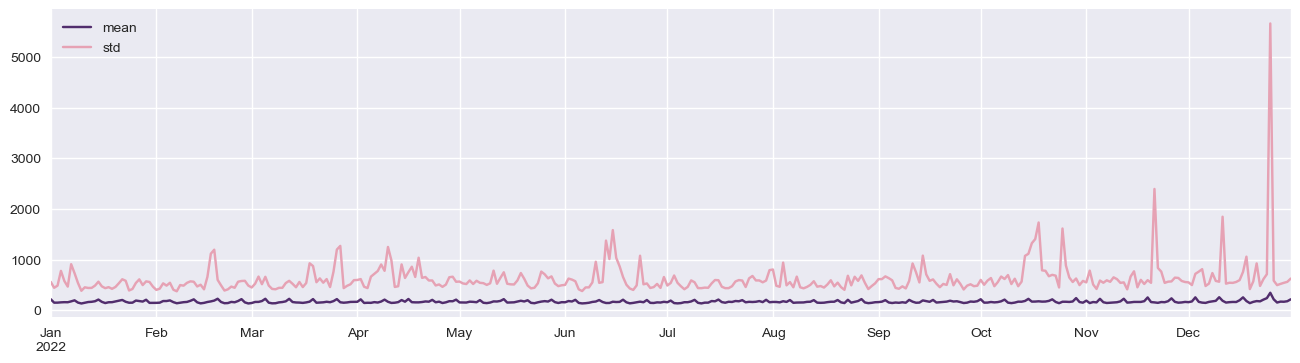

In [94]:
daily_distribution = pd.DataFrame([], columns = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']) 
date_range = pd.date_range(start="2021-01-01",end="2022-12-31")

for d in date_range:
    df_day = df.loc[df['DATE_DIM'] == d, 'TOTAL_TURNOVER']
    dis = df_day.describe().to_frame().transpose()
    
    daily_distribution = daily_distribution.append(dis)
    
daily_distribution.index = date_range

daily_distribution.loc[daily_distribution.index.year==2022  ,['mean', 'std']].plot()

### a) RACING vs SPORT and FOB vs PARI

Western Australia TAB is primarily a racing wagering company, sport betting is considered a side category. Therefore, we will see that the trend of racing turnover will overwhelm the other. The gap is not as drastic for FOB vs. PARI.

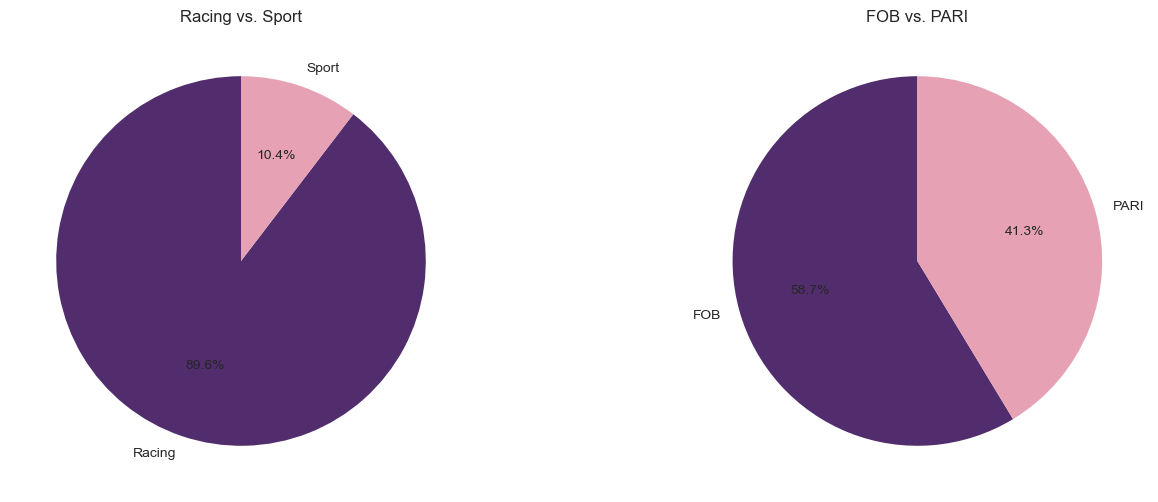

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))

ax[0].pie(df[['RACING_TURNOVER', 'SPORT_TURNOVER']].sum(axis=0), labels= ["Racing", 'Sport'], autopct='%1.1f%%', startangle=90)
ax[0].set_title('Racing vs. Sport')

ax[1].pie(df[['FOB_TURNOVER', 'PARI_TURNOVER']].sum(axis=0), labels= ["FOB", 'PARI'], autopct='%1.1f%%', startangle=90)
ax[1].set_title('FOB vs. PARI')

plt.show();

### b) Trends

We can explore the daily total turnover and identify trends.

#### Aggregate

In [15]:
# Aggregate by day
df_agg = df.set_index('DATE_DIM').resample('d')[['RACING_TURNOVER', 'SPORT_TURNOVER', 'FOB_TURNOVER', 'PARI_TURNOVER', 
                                                 'TOTAL_TURNOVER', 'DIVIDENDS_PAID', 'GROSS_MARGIN', 'TICKETS']].sum()

# Preview
df_agg.head()

,RACING_TURNOVER,SPORT_TURNOVER,FOB_TURNOVER,PARI_TURNOVER,TOTAL_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS
DATE_DIM,,,,,,,,
2021-01-01,3675463.56,160299.45,1900648.00,1935115.01,3835763.01,3114833.37,612209.61,488284
2021-01-02,5908319.48,257615.55,3587422.50,2578512.53,6165935.03,4950837.44,1108786.73,698304
2021-01-03,1866557.48,331455.71,1262085.50,935927.69,2198013.19,1826858.93,329320.26,280706
2021-01-04,1201729.24,321883.43,908516.50,615096.17,1523612.67,1287301.59,199908.63,194321
2021-01-05,1255772.61,225060.21,827286.50,653546.32,1480832.82,1213781.16,251753.98,201566


#### 2021 vs 2022 trend

In [16]:
# 2021 vs 2022
df_agg_2021 = df_agg[df_agg.index.year == 2021]
df_agg_2022 = df_agg[df_agg.index.year == 2022]

In [17]:
print("Total turnover in 2021 : ", df_agg_2021['TOTAL_TURNOVER'].sum())
print("Total turnover in 2022 : ", df_agg_2022['TOTAL_TURNOVER'].sum())

Total turnover in 2021 :  1103904371.1399999
Total turnover in 2022 :  1090985007.02


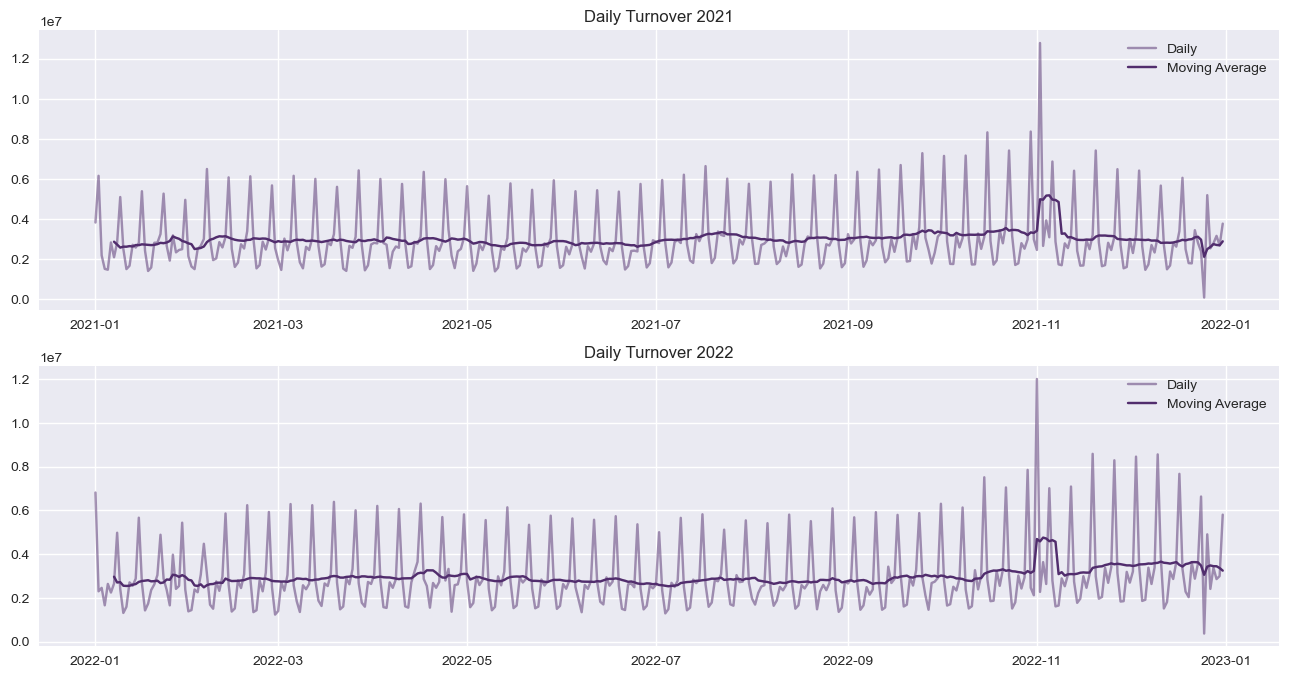

In [18]:
# 7 day moving average
df_agg_rolling_2021 = df_agg_2021['TOTAL_TURNOVER'].rolling(window=7).mean()
df_agg_rolling_2022 = df_agg_2022['TOTAL_TURNOVER'].rolling(window=7).mean()

# Visualize
fig, ax = plt.subplots(2, figsize=(16,8))

ax[0].plot(df_agg_2021['TOTAL_TURNOVER'], color="#512d6d", alpha=0.5, label = 'Daily')
ax[0].plot(df_agg_rolling_2021, label='Moving Average')
ax[0].legend()
ax[0].set_title('Daily Turnover 2021')

ax[1].plot(df_agg_2022['TOTAL_TURNOVER'], color="#512d6d", alpha=0.5, label = 'Daily')
ax[1].plot(df_agg_rolling_2022, label='Moving Average')
ax[1].legend()
ax[1].set_title('Daily Turnover 2022')

plt.show()

The turnover trend is pretty consistent throughout the year with bottoming on Monday and peaking on Saturday. This is perfectly suitable for time series models like Exponential Smoothing.

There is no sudden upward or downward movement except two anomalies:
- Peak: Melbourne Cup, first Tuesday of November
- Bottom: Christmas day, the company closes racing wagering on 12-25 every year
We have to factor these outliers into the model

To see the parttern clearer, we can plot a weekly average

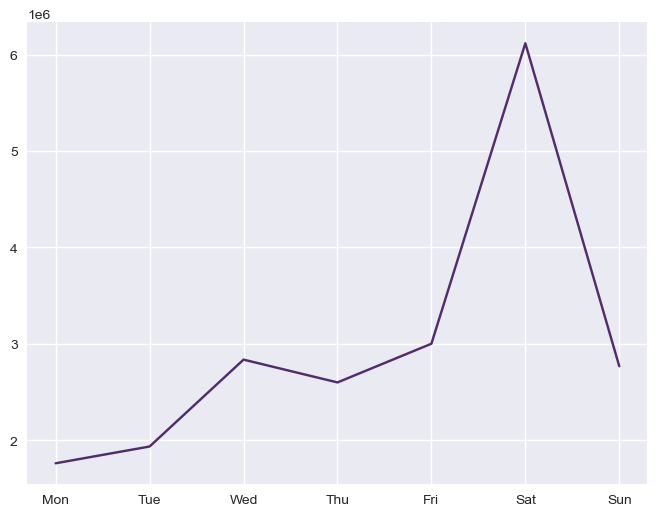

In [19]:
df_weekly = df_agg.groupby(df_agg.index.weekday).TOTAL_TURNOVER.mean()
df_weekly.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Visualize
fig, ax = plt.subplots(1, figsize=(8,6))
ax.plot(df_weekly)

<b>By now, we can safely presume the trends in 2022 and 2021 are parallel. We decide to choose 2022 as the year to focus on to obtain more insights.

#### RACING_TURNOVER vs SPORT_TURNOVER


As can seen in the plots, the two patterns are distinct. Racing trend is more similar to the overall trend because it accounts for 90% of the total turnover. The line flucuantes much more with sport turnover but we can spot a surge from March to September. That is the Australian Football League season starting on 2022-03-16 and finalizing on 2022-09-24.

With two much dissimilar trends, we can create two exponential smoothing models then aggregate the predicted values. It is the way we can customize and factor in these outliers.

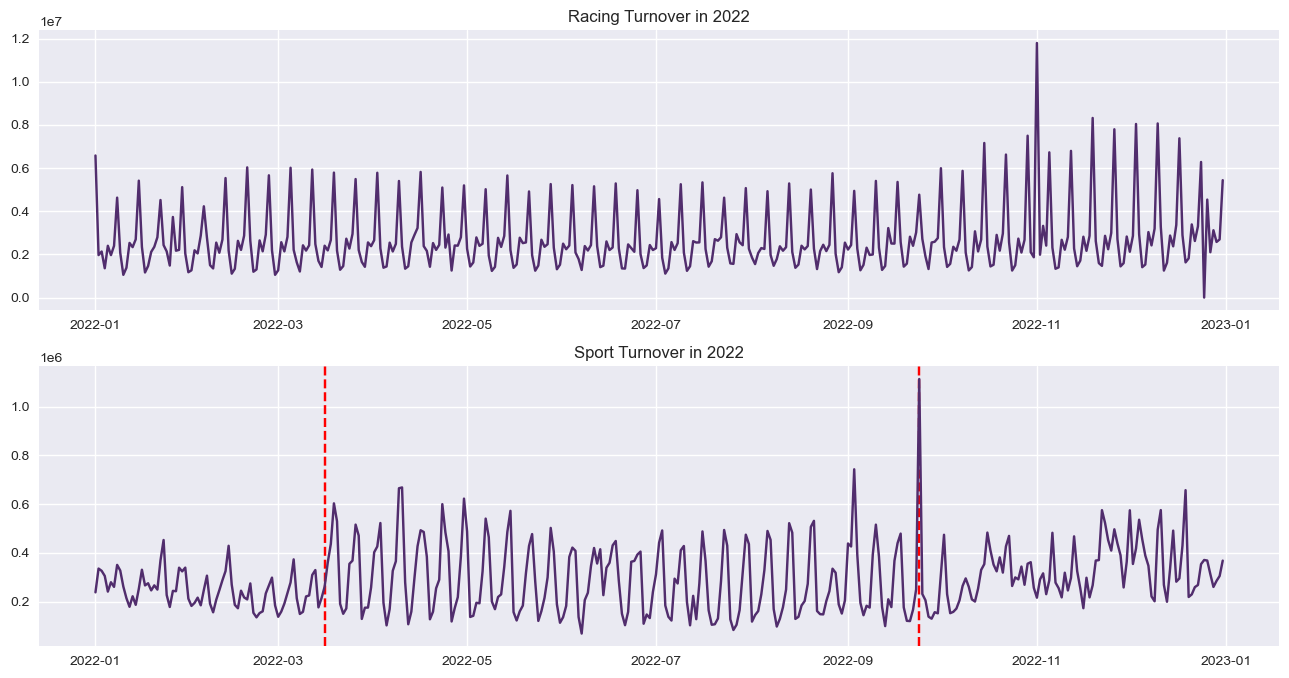

In [20]:
fig, ax = plt.subplots(2, figsize=(16,8))

ax[0].plot(df_agg_2022['RACING_TURNOVER'])
ax[0].set_title('Racing Turnover in 2022')

threshold_1 = datetime(2022, 3, 16)
threshold_2 = datetime(2022, 9, 24)
threshold_mpl_1 = mdates.date2num(threshold_1)
threshold_mpl_2 = mdates.date2num(threshold_2)

ax[1].axvline(threshold_mpl_1 , color='red', linestyle='--')
ax[1].axvline(threshold_mpl_2 , color='red', linestyle='--')

ax[1].plot(df_agg_2022['SPORT_TURNOVER'])
ax[1].set_title('Sport Turnover in 2022')

plt.show()

#### Average ticket value

Average ticket value stays consistent throughout the year except the Christmas day. 

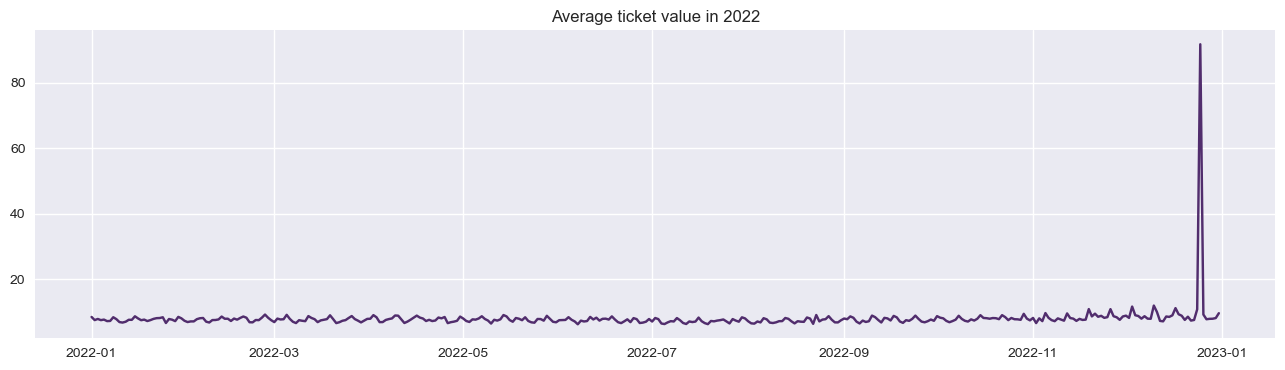

In [23]:
df_avg = df_agg_2022['TOTAL_TURNOVER'] / df_agg_2022['TICKETS']

# Visualize
fig, ax = plt.subplots(1, figsize=(16,4))
ax.plot(df_avg)
plt.title("Average ticket value in 2022")
plt.show()

### c) Correlation with other factors

### Correlation matrix

We can see that other features (`DIVIDENDS_PAID`,`GROSS_MARGIN`,`TICKETS`... ) heavily correlate with TOTAL_TURNOVER. `SPORT_TURNOVER` can vary drastically so it isn't linearly related. It lines up with our analysis above.

In [ ]:
# Correlation maxtrix
df_corr = df_agg.corr()

plt.figure(figsize=(8,6))

cmap = sns.light_palette("#512d6d", as_cmap=True)
sns.heatmap(df_corr, cmap=cmap, vmin=0, vmax=1 , annot=True, fmt=".2f")
plt.title("Correllation Heatmap")

plt.plot();

In [47]:
t = df[df['DATE_DIM'].dt.year == 2022].set_index('DATE_DIM').resample('W').BET_ACCOUNT_NUM_HASH.nunique()

In [48]:
e  = df_agg_2022.resample('W').TOTAL_TURNOVER.sum() / t

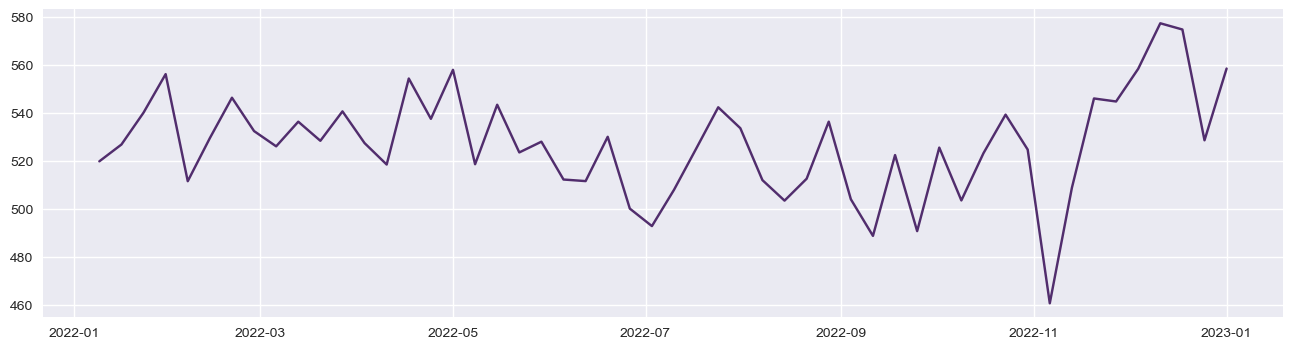

In [52]:
plt.plot(e[1:])

### Gross margin

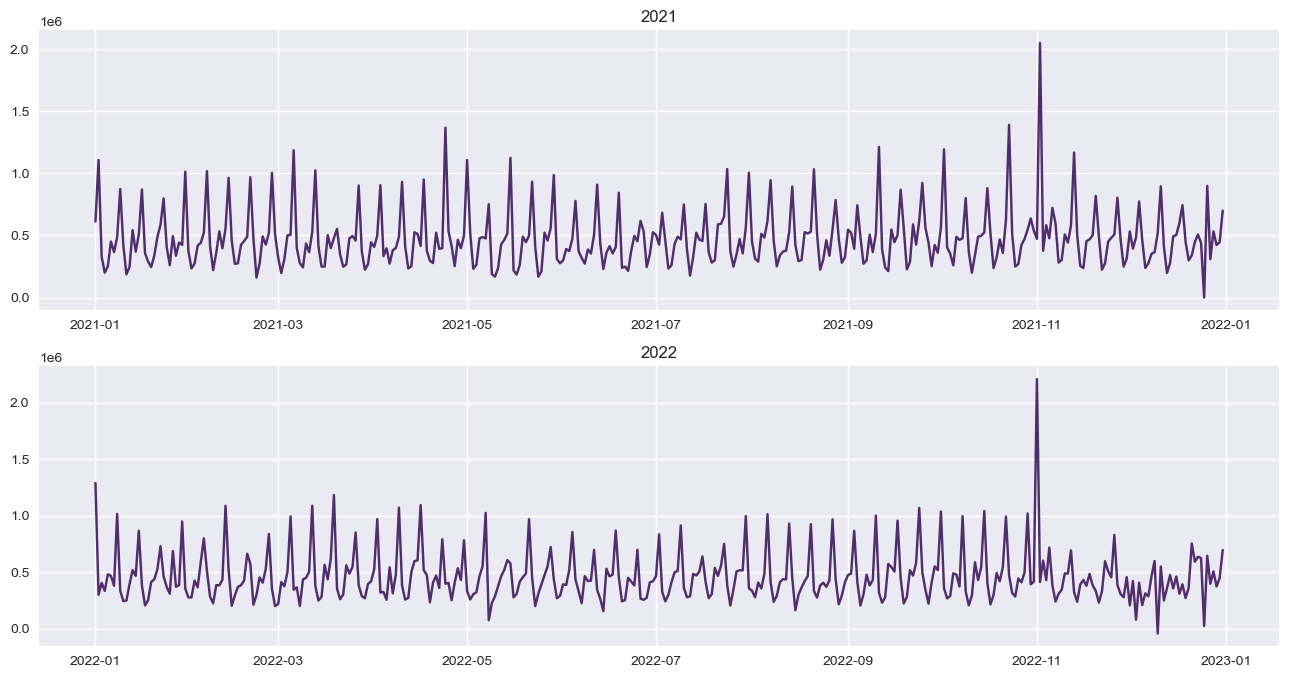

In [27]:
# Visualize
fig, ax = plt.subplots(2, figsize=(16,8))

ax[0].plot(df_agg_2021['GROSS_MARGIN'])
ax[0].set_title('2021')

ax[1].plot(df_agg_2022['GROSS_MARGIN'])
ax[1].set_title('2022')

plt.show()

### DIVIDENDS PAID

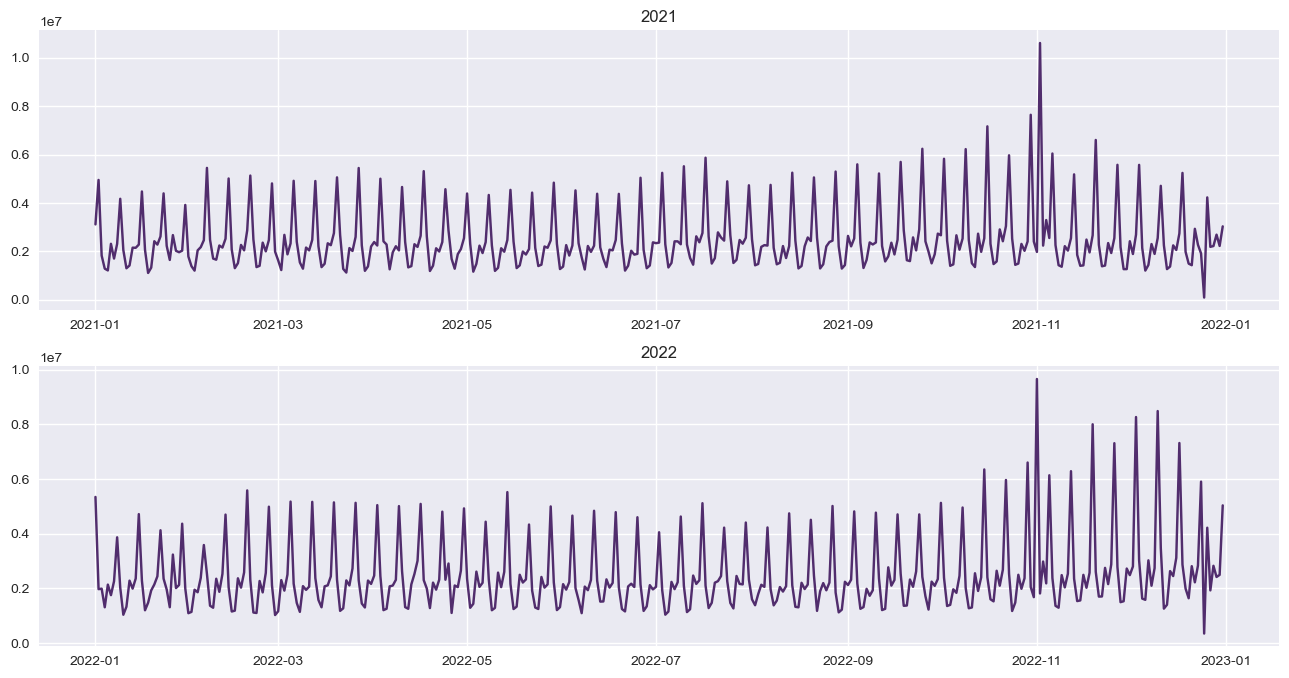

In [28]:
# Visualize
fig, ax = plt.subplots(2, figsize=(16,8))

ax[0].plot(df_agg_2021['DIVIDENDS_PAID'])
ax[0].set_title('2021')

ax[1].plot(df_agg_2022['DIVIDENDS_PAID'])
ax[1].set_title('2022')

plt.show()

### Dividends paid / total turnover

In [29]:
df_div_per =  df_agg_2022['DIVIDENDS_PAID'] / df_agg_2022['TOTAL_TURNOVER'] * 100

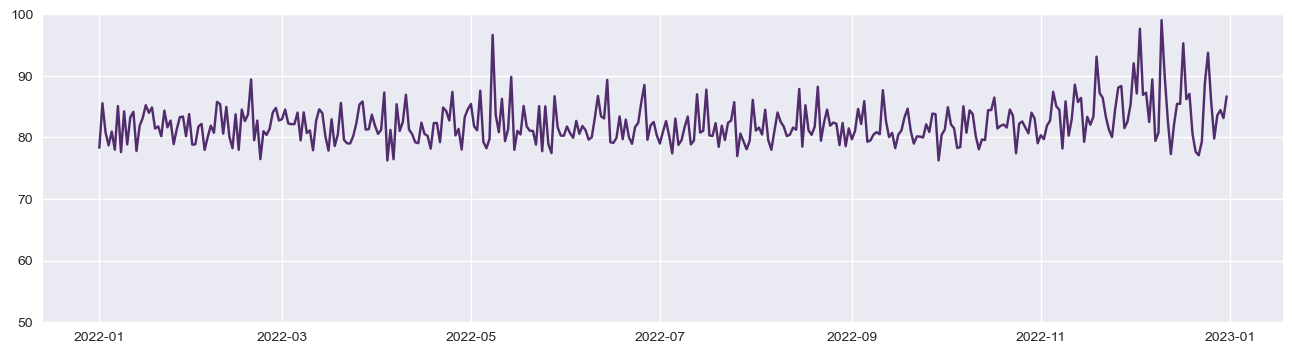

In [30]:
fig, ax = plt.subplots(1, figsize=(16,4))

ax.plot(df_div_per)
ax.set_ylim((50,100))
    
plt.show()

In [31]:
df_div_per.var()

11.283676962842934

In [32]:
df_div_per.mean()

82.29626539722426

(array([13., 45., 77., 76., 56., 41., 25., 17.,  7.,  1.,  1.,  2.,  1.,
         1.,  2.]),
 array([76.26401049, 77.78265642, 79.30130235, 80.81994828, 82.33859422,
        83.85724015, 85.37588608, 86.89453201, 88.41317794, 89.93182387,
        91.4504698 , 92.96911573, 94.48776166, 96.00640759, 97.52505352,
        99.04369946]),
 <BarContainer object of 15 artists>)

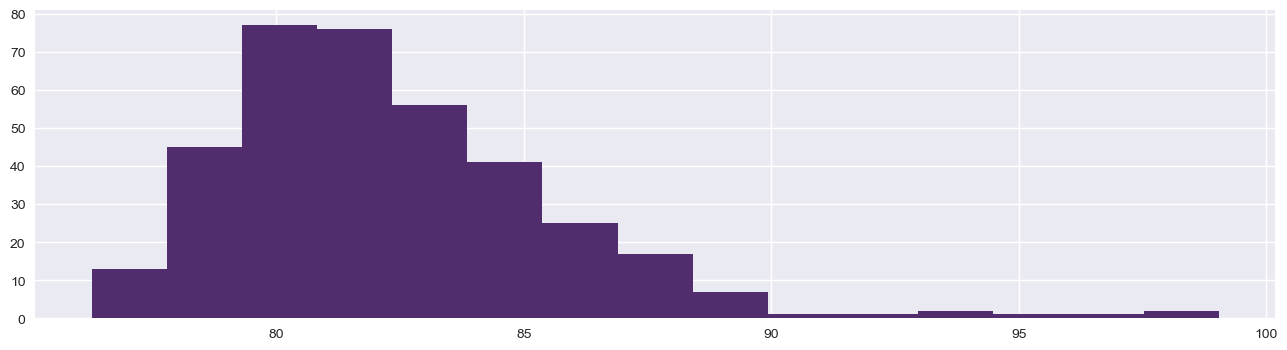

In [33]:
plt.hist(df_div_per, bins=15)

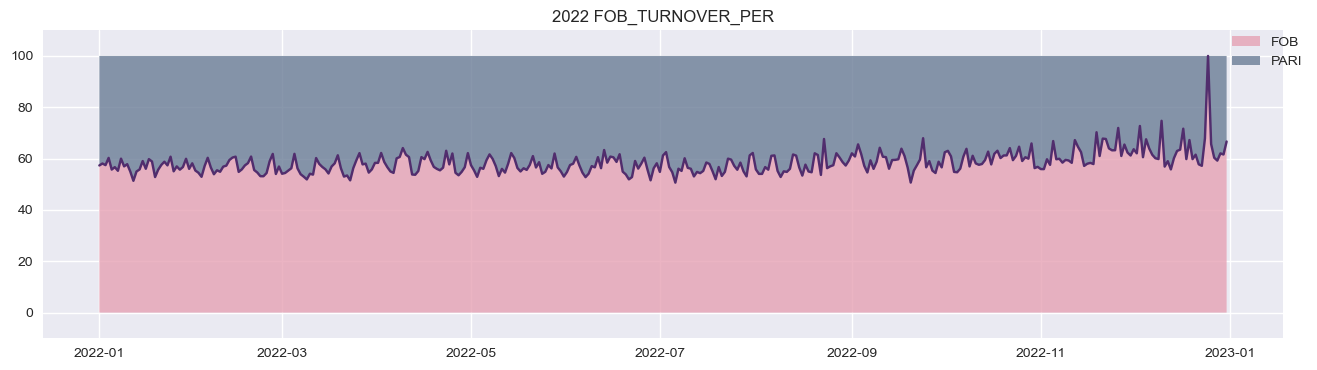

In [49]:
## 2022: FOB vs PARI ratio
fig, ax = plt.subplots(1, figsize=(16,4))

df_agg_2022['FOB_TURNOVER_PER'] = df_agg_2022['FOB_TURNOVER'] / df_agg_2022['TOTAL_TURNOVER'] * 100
df_agg_2022['PARI_TURNOVER_PER'] = 100 - df_agg_2022['FOB_TURNOVER_PER']

ax.plot(df_agg_2022['FOB_TURNOVER_PER'])
plt.stackplot(df_agg_2022.index, df_agg_2022['FOB_TURNOVER_PER'], df_agg_2022['PARI_TURNOVER_PER'], labels=['FOB', 'PARI'], alpha=0.8)

ax.set_title('2022 FOB_TURNOVER_PER')
ax.legend(loc='best', bbox_to_anchor=(1.02, 1), borderaxespad=0)
ax.set_ylim(-10,110)

plt.show()

## EDA Customer

In [14]:
# Aggregate data
cus_df = df.groupby('BET_ACCOUNT_NUM_HASH', as_index=False) \
            .agg({'AGE': max, 
                  'GENDER': max,
                  'TENURE_IN_DAYS' : min,
                  'RESIDENTIAL_STATE' : min, 
                  'DATE_DIM': [min, max, np.size],
                  'RACING_TURNOVER' : sum, 
                  'SPORT_TURNOVER' : sum, 
                  'FOB_TURNOVER' : sum, 
                  'PARI_TURNOVER' : sum, 
                  'TOTAL_TURNOVER' : sum, 
                  'DIVIDENDS_PAID' : sum,
                  'GROSS_MARGIN' : sum, 
                  'TICKETS' : sum})

# Rename columns
cus_df.columns = ["_".join(x).upper() if x[0] == "DATE_DIM" else x[0] for x in cus_df.columns.ravel() ]

cus_df.head()

,BET_ACCOUNT_NUM_HASH,AGE,GENDER,TENURE_IN_DAYS,RESIDENTIAL_STATE,DATE_DIM_MIN,DATE_DIM_MAX,DATE_DIM_SIZE,RACING_TURNOVER,SPORT_TURNOVER,FOB_TURNOVER,PARI_TURNOVER,TOTAL_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS
0,13154,67.00,M,11846,WA,2021-01-01,2022-12-31,463,366186.08,0.00,31113.00,335073.08,366186.08,270817.07,81925.97,113627
1,18379,54.00,M,1884,WA,2021-01-01,2022-12-31,195,31934.00,99.00,28021.00,4012.00,32033.00,23658.86,6645.73,836
2,37251,22.00,U,0,WA,2022-11-01,2022-11-01,1,100.00,0.00,65.00,35.00,100.00,760.00,-689.65,7
3,129273,22.00,U,0,WA,2021-12-26,2022-12-19,16,62.00,93.00,155.00,0.00,155.00,149.45,5.55,37
4,348318,29.00,U,0,WA,2022-06-10,2022-09-24,4,25.00,5.00,27.00,3.00,30.00,0.00,27.58,17


### Unique customers

In [15]:
print("Total unique customers : ", cus_df.shape[0])

print("Total unique customers in 2021 : ", df.loc[df['DATE_DIM'].dt.year == 2021, 'BET_ACCOUNT_NUM_HASH'].nunique())

print("Total unique customers in 2022 : ", df.loc[df['DATE_DIM'].dt.year == 2022, 'BET_ACCOUNT_NUM_HASH'].nunique())

Total unique customers :  144829
Total unique customers in 2021 :  110497
Total unique customers in 2022 :  116456


### Weekly customers

<Axes: xlabel='DATE_DIM'>

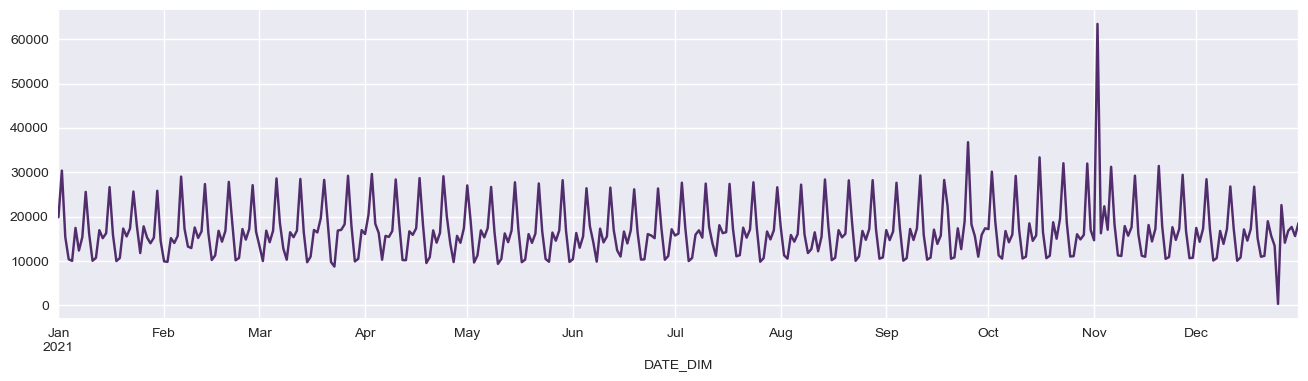

In [16]:
plt.figure(figsize=(16,4))

cus_num_df = df.set_index('DATE_DIM').resample('d').BET_ACCOUNT_NUM_HASH.size()

cus_num_df[:365].plot()

In [17]:
df.set_index('DATE_DIM').groupby('GENDER').resample('d').size()

MemoryError: Unable to allocate 1.10 GiB for an array with shape (12, 12320755) and data type float64

### New customers

In [ ]:
new_cus_df = df[df['TENURE_IN_DAYS'] == 0 ].groupby('BET_ACCOUNT_NUM_HASH', as_index=False).agg({'DATE_DIM' : min})
new_cus_df.set_index('DATE_DIM').resample('W').BET_ACCOUNT_NUM_HASH.size().plot(figsize=(16,4))

### One-time customer

In [ ]:
one_time_cus_df = df[df['BET_ACCOUNT_NUM_HASH'].isin(new_cus_df.BET_ACCOUNT_NUM_HASH)].groupby('BET_ACCOUNT_NUM_HASH').agg({
    'BET_ACCOUNT_NUM_HASH' : "count",
    'DATE_DIM' : min
})
one_time_cus_df

In [ ]:
one_time_cus_df = one_time_cus_df[one_time_cus_df['BET_ACCOUNT_NUM_HASH'] == 1]
one_time_cus_df = one_time_cus_df.drop('BET_ACCOUNT_NUM_HASH', axis=1).reset_index()

In [ ]:
one_time_cus_df.set_index('DATE_DIM').resample('W').BET_ACCOUNT_NUM_HASH.size().plot(figsize=(16,4))

### Describe

In [ ]:
cus_df.describe()

### Correlation matrix

In [18]:
col_list = ['AGE' , 'TENURE_IN_DAYS', 'DATE_DIM_SIZE' , 'TOTAL_TURNOVER',
            'DIVIDENDS_PAID', 'GROSS_MARGIN' , 'TICKETS']

cus_corr_df = cus_df[col_list].corr()

<Axes: >

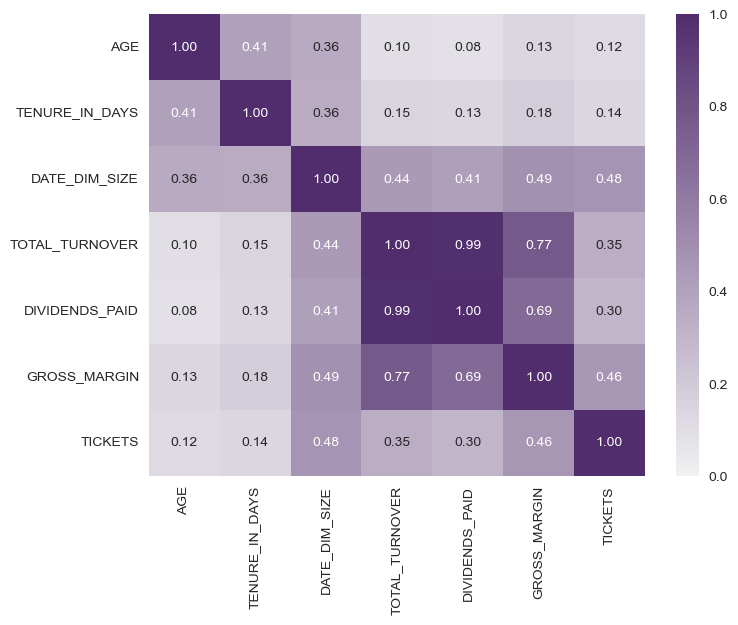

In [19]:
plt.figure(figsize=(8,6))

color = '#512d6d'
cmap = sns.light_palette("#512d6d", as_cmap=True)

sns.heatmap(cus_corr_df, cmap=cmap, vmin=0, vmax=1, annot=True, fmt=".2f")

### Age

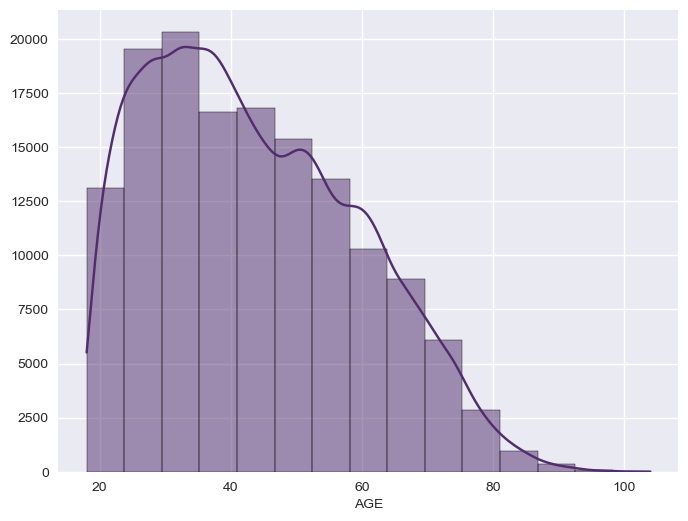

In [57]:
# Age distribution
plt.figure(figsize=(8,6))
sns.histplot(cus_df['AGE'], kde=True, bins=15)
plt.ylabel("")

plt.show();

Pretty normal with a right tail

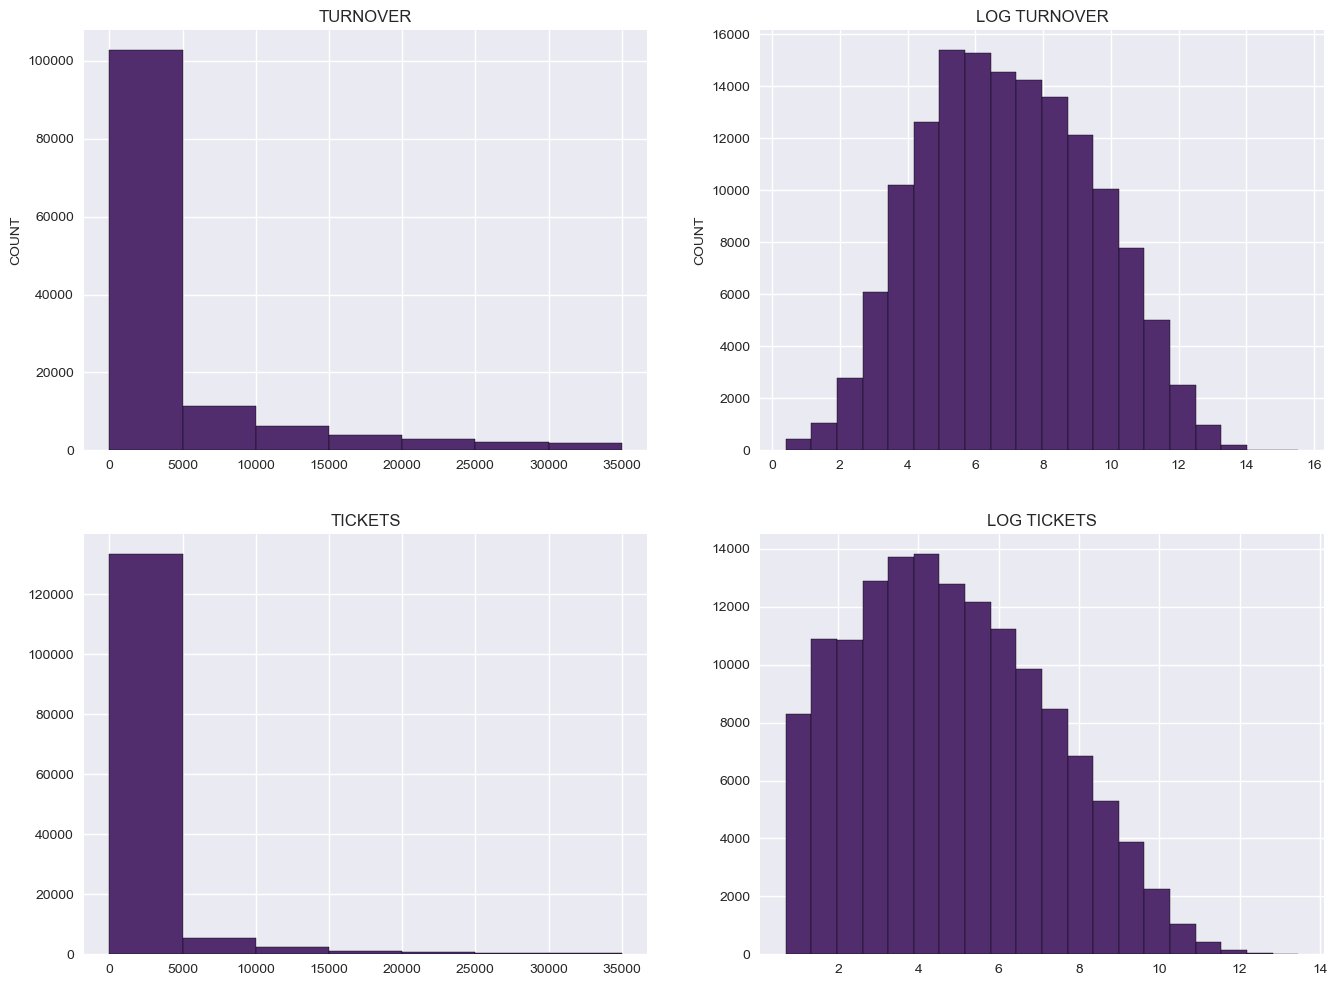

In [38]:
# TURNOVER and TICKETS
fig, ax = plt.subplots(2,2, figsize=(16,12))

ax[0,0].hist(cus_df['TOTAL_TURNOVER'], bins=range(0,40000, 5000), edgecolor='black')
ax[0,0].set_ylabel('COUNT')
ax[0,0].set_title('TURNOVER')

ax[0,1].hist(np.log(cus_df['TOTAL_TURNOVER']+1), bins=20, edgecolor='black')
ax[0,1].set_ylabel('COUNT')
ax[0,1].set_title('LOG TURNOVER')

ax[1,0].hist(cus_df['TICKETS'], bins=range(0,40000, 5000), edgecolor='black')
ax[1,0].set_title('TICKETS')

ax[1,1].hist(np.log(cus_df['TICKETS']+1), bins=20, edgecolor='black')
ax[1,1].set_title('LOG TICKETS')

plt.show();

We notice exponential decays with these two distributions. Therefore, a log transformation would work great here to convert the distribution in Gaussian when modelingm.

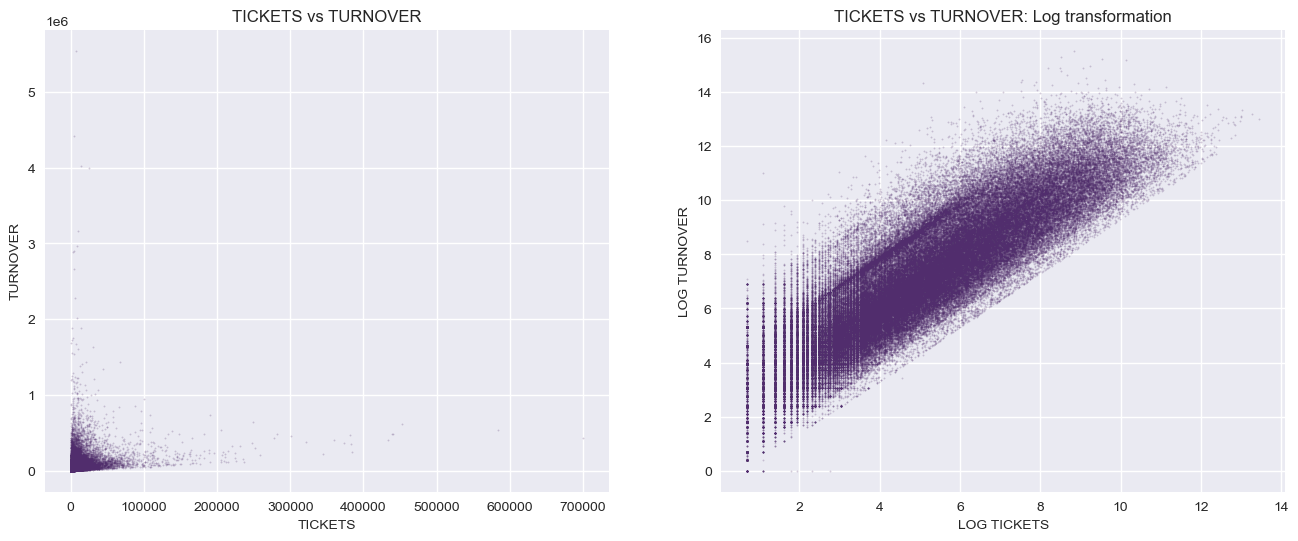

In [59]:
fig, ax = plt.subplots(1,2, figsize=(16,6))

ax[0].scatter(cus_df['TICKETS'] , cus_df['TOTAL_TURNOVER'] , s=1, alpha=0.2)
ax[0].set_title('TICKETS vs TURNOVER')
ax[0].set_xlabel('TICKETS')
ax[0].set_ylabel('TURNOVER')

ax[1].scatter(np.log(cus_df['TICKETS']+1) , np.log(cus_df['TOTAL_TURNOVER']+1) , s=1, alpha=0.2)
ax[1].set_title('TICKETS vs TURNOVER: Log transformation')
ax[1].set_xlabel('LOG TICKETS')
ax[1].set_ylabel('LOG TURNOVER')

plt.show()

In [60]:
#LOG TURNOVER and LOG TICKETS corr
np.corrcoef(np.log(cus_df['TOTAL_TURNOVER']+1), np.log(cus_df['TICKETS']+1))[0,1]

0.8778874226852929

We detect strong heteroscedascity between TICKETS and TURNOVER (left fig). Therefore, we log transform both columns to achieve balanced variance (right fig).

### TURNOVER vs DIVIDENDS_PAID 

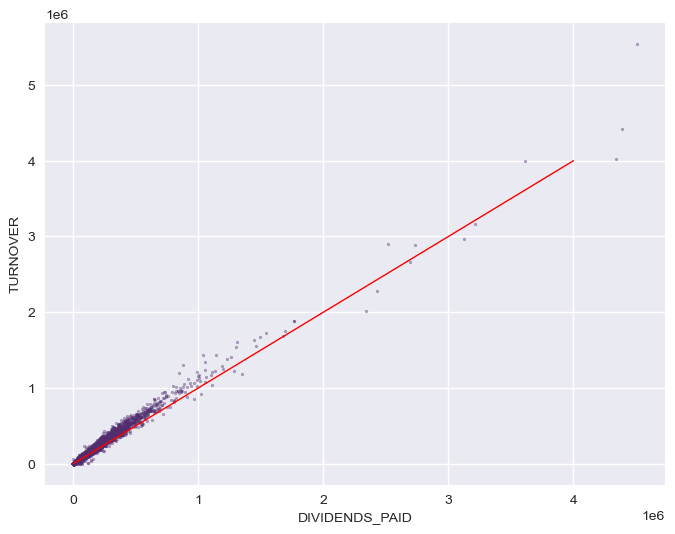

In [61]:
plt.figure(figsize=(8,6))

plt.scatter(cus_df['DIVIDENDS_PAID'], cus_df['TOTAL_TURNOVER'], s=4, alpha=0.4)
plt.plot([0, 4e6], [0, 4e6], linewidth=1, c='r' )

plt.xlabel('DIVIDENDS_PAID')
plt.ylabel('TURNOVER')
plt.show();

DIVIDENDS_PAID almost completely linearly correlate with TURNOVER. GROSS_MARGIN has a considerably strong correlation with TURNOVER too. AGE and TICKETS appear to be weakly related to TURNOVER.

I might seem that the more you invest, the bigger you win. That's only half of the story. The red line indicates the break even boundary. We have to analyze the variance to truly understand the risk.

### AGE vs TURNOVER

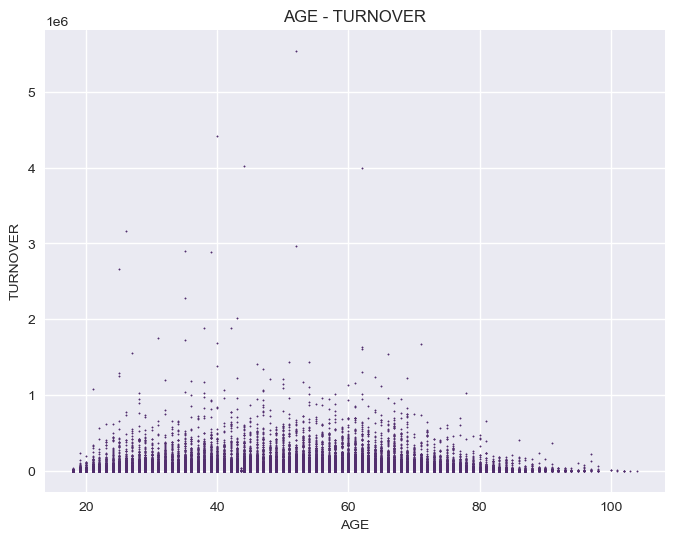

In [62]:
plt.figure(figsize=(8,6))

plt.scatter(cus_df['AGE'] , cus_df['TOTAL_TURNOVER'] , s=1)
plt.title('AGE - TURNOVER')
plt.xlabel('AGE')
plt.ylabel('TURNOVER')

plt.show()

No correllation

### RACING_TURNOVER vs SPORT_TURNOVER

In [63]:
cus_df[['RACING_TURNOVER', 'SPORT_TURNOVER']].sum(axis=0)

RACING_TURNOVER   1966781571.05
SPORT_TURNOVER     228100633.91
dtype: float64

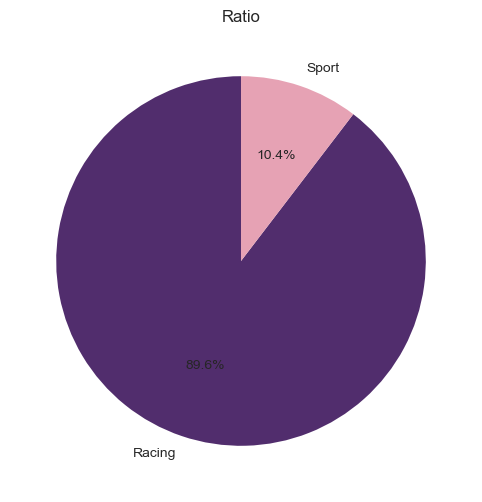

In [64]:
fig, ax = plt.subplots(1, figsize=(8,6))

ax.pie(cus_df[['RACING_TURNOVER', 'SPORT_TURNOVER']].sum(axis=0), labels= ["Racing", 'Sport'], autopct='%1.1f%%', startangle=90)
ax.set_title('Ratio')

plt.show();

Most people most of their money on horse racing instead of other sports (most presumingly Australian football). However, tt's noteworthy to point out that a considerable amount of customers like to spend 90% of their money on other sports. 

#### Gender

In [40]:
test1 = cus_df.groupby('GENDER').TOTAL_TURNOVER.mean()

#### RESIDENTIAL_STATE

In [26]:
cus_df.groupby('RESIDENTIAL_STATE').TOTAL_TURNOVER.mean()

RESIDENTIAL_STATE
OTH   12088.72
WA    15834.88
Name: TOTAL_TURNOVER, dtype: float64

In [34]:
bins = [18,25,35,45,55,65, np.inf]
cus_df['AGE_BAND'] = pd.cut(cus_df['AGE'], right=False, bins=bins)

In [41]:
test2 = cus_df.groupby('AGE_BAND').TOTAL_TURNOVER.mean()

In [46]:
["18-24", "25-34", "35-44", "45-54", "55-64", "65-"]

AGE_BAND
[18.0, 25.0)    4826.63
[25.0, 35.0)    9244.10
[35.0, 45.0)   13784.95
[45.0, 55.0)   18631.94
[55.0, 65.0)   24694.17
[65.0, inf)    22137.50
Name: TOTAL_TURNOVER, dtype: float64

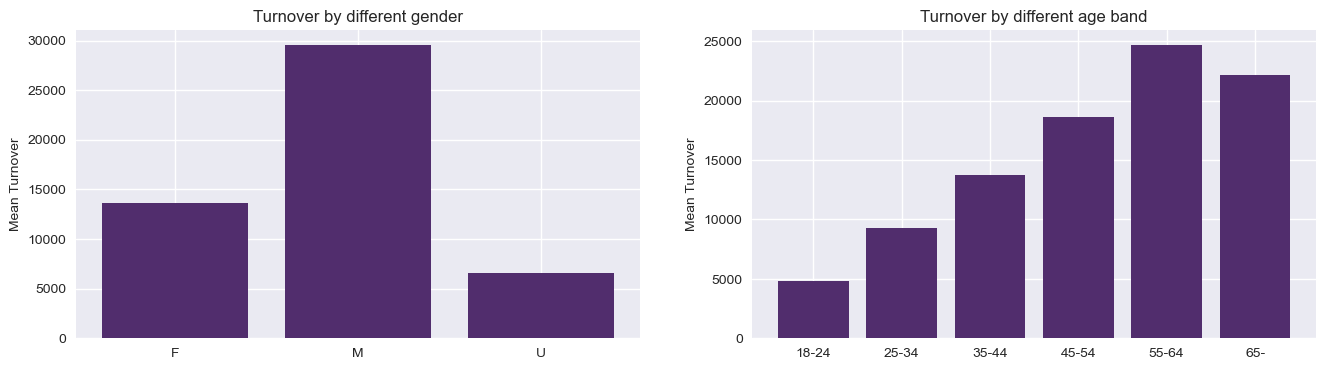

In [48]:
fig, ax = plt.subplots(1,2)

ax[0].bar(test1.index, test1)
ax[0].set_ylabel("Mean Turnover")
ax[0].set_title("Turnover by different gender")

ax[1].bar(["18-24", "25-34", "35-44", "45-54", "55-64", "65-"], test2)
ax[1].set_ylabel("Mean Turnover")
ax[1].set_title("Turnover by different age band")

# Display the chart
plt.show()